In [146]:
from lussi.stackoverflow import *
from lussi.ziprecruiter import *
%matplotlib inline

nogit_data_dir = "608data_nogit"

## to load, use these.
# raw_stack  = load_stack(data_dir = nogit_data_dir, stack_type=StackType.RAW)
# wide_stack = load_stack(data_dir = nogit_data_dir, stack_type=StackType.WIDE)
ziprecruiter = load_zip(data_dir = nogit_data_dir)


Loading data from 608data_nogit/combined_salaries.csv


In [143]:
ziprecruiter.head()

,State,Annual Salary,Monthly Pay,Weekly Pay,Hourly Wage,Job Title,Abbreviation,Salary Tier
0,New York,136172,11347,2618,65.47,Data Scientist,NY,120K-140K
1,Vermont,133828,11152,2573,64.34,Data Scientist,VT,120K-140K
2,California,131441,10953,2527,63.19,Data Scientist,CA,120K-140K
3,Maine,127644,10637,2454,61.37,Data Scientist,ME,120K-140K
4,Idaho,126275,10522,2428,60.71,Data Scientist,ID,120K-140K


In [140]:
print(ziprecruiter.head())
print(ziprecruiter.info())
print(ziprecruiter.describe())
print(ziprecruiter[['Job Title']].drop_duplicates())

        State  Annual Salary  Monthly Pay  Weekly Pay  Hourly Wage  \
0    New York         136172        11347        2618        65.47   
1     Vermont         133828        11152        2573        64.34   
2  California         131441        10953        2527        63.19   
3       Maine         127644        10637        2454        61.37   
4       Idaho         126275        10522        2428        60.71   

        Job Title Abbreviation Salary Tier  
0  Data Scientist           NY   120K-140K  
1  Data Scientist           VT   120K-140K  
2  Data Scientist           CA   120K-140K  
3  Data Scientist           ME   120K-140K  
4  Data Scientist           ID   120K-140K  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          350 non-null    object 
 1   Annual Salary  350 non-null    int64  
 2   Monthly Pay    350 non-n

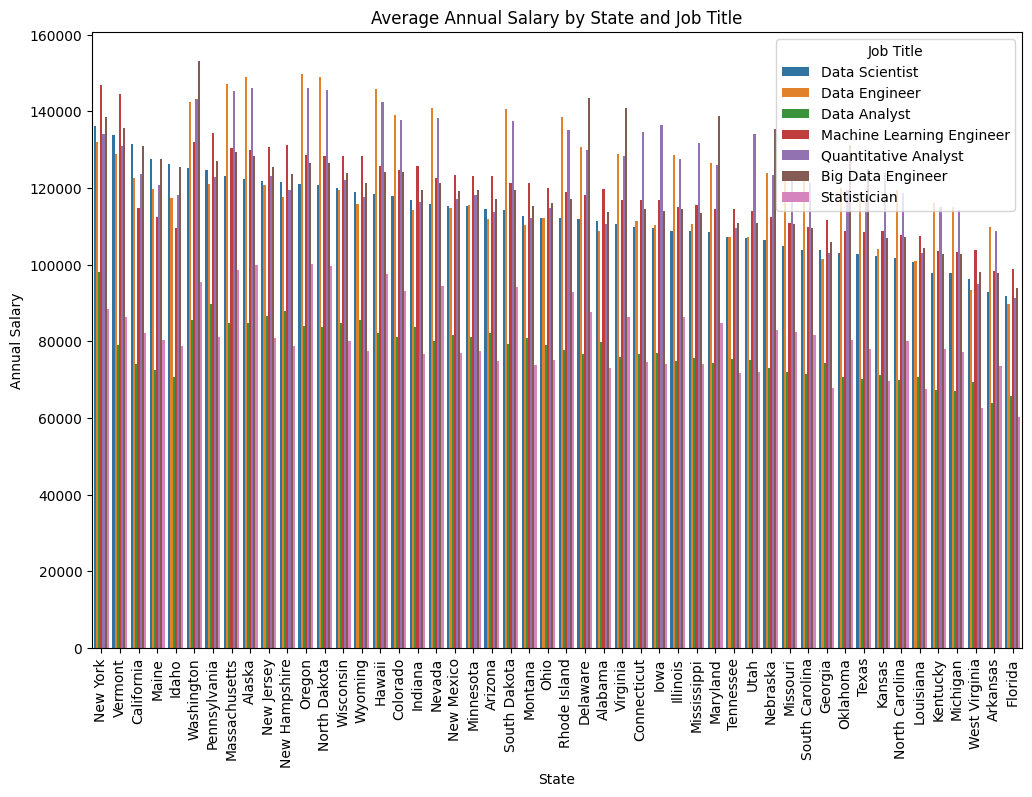

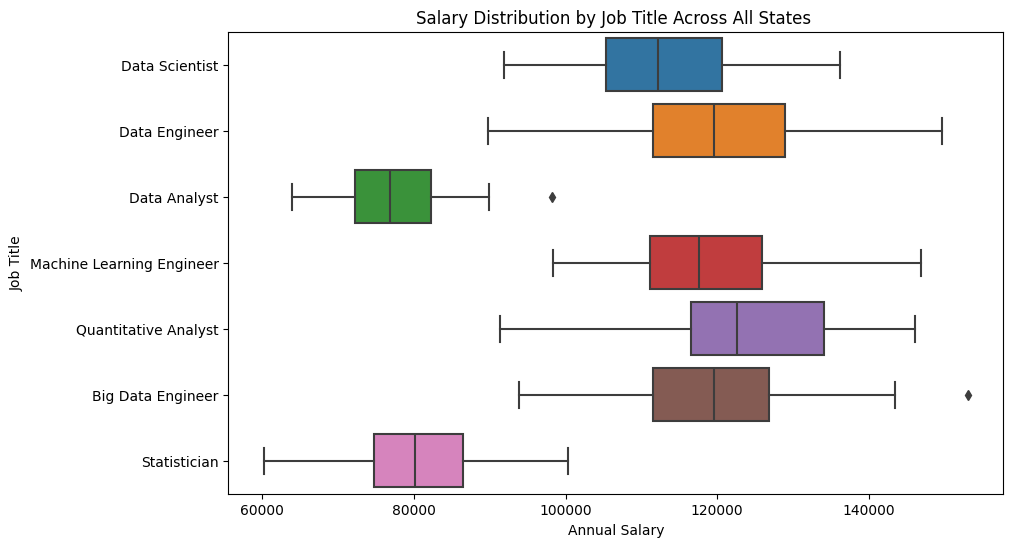

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouped Bar Chart: Job Role vs. State
plt.figure(figsize=(12, 8))
sns.barplot(x='State', y='Annual Salary', hue='Job Title', data=ziprecruiter)
plt.xticks(rotation=90)
plt.title('Average Annual Salary by State and Job Title')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(y='Job Title', x='Annual Salary', data=ziprecruiter, orient='h')  # 'h' for horizontal orientation
plt.title('Salary Distribution by Job Title Across All States ')
plt.show()


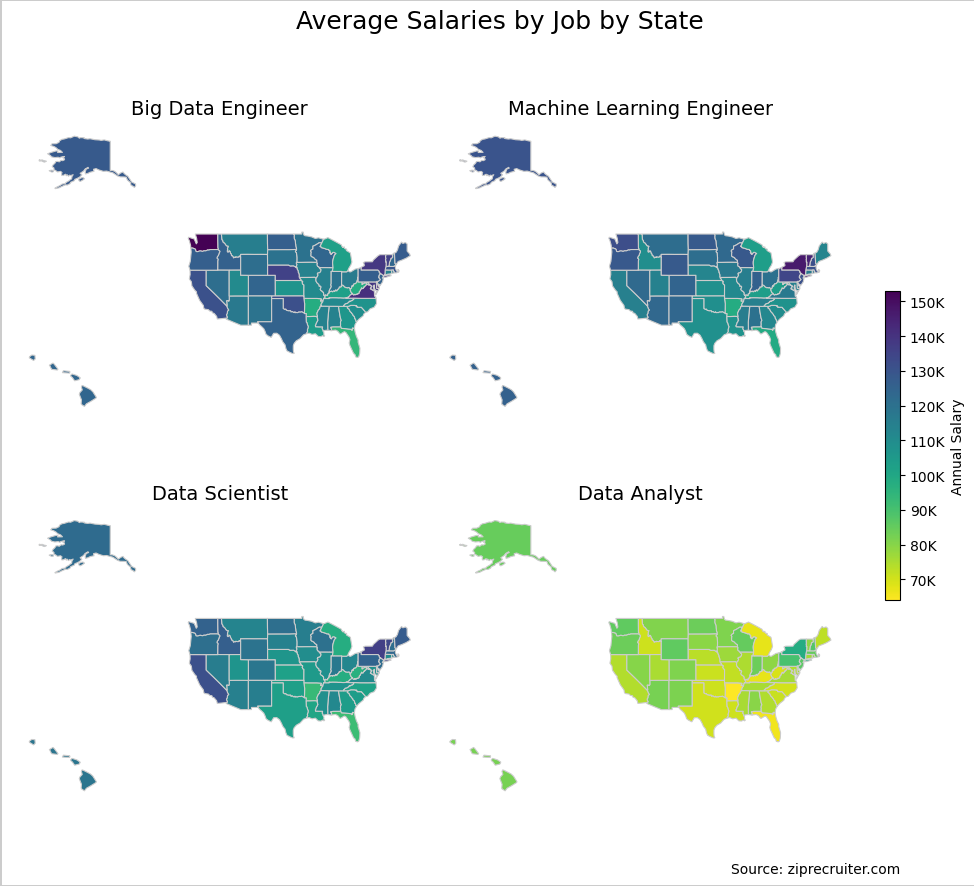

In [145]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

df = ziprecruiter

# Load the shapefile for US states
shapefile_path = 'nogit_data_archive/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp'
gdf = gpd.read_file(shapefile_path)

# Filter to US states only by matching 'United States of America'
gdf = gdf[gdf['admin'] == 'United States of America']

# Ensure both GeoDataFrame and DataFrame have matching columns for merging
gdf['Abbreviation'] = gdf['postal'].str.upper()

# Example DataFrame 'df' (your salary data) already contains 'Abbreviation' column
df['Abbreviation'] = df['Abbreviation'].str.upper()

# Filter out "Quantitative Analyst", "Statistician", and "Data Engineer" from job titles
df = df[~df['Job Title'].isin(["Quantitative Analyst", "Statistician", "Data Engineer"])]

# Compute average salary by job title
average_salaries = df.groupby('Job Title')['Annual Salary'].mean().sort_values(ascending=False)
sorted_job_titles = average_salaries.index.tolist()

# Set a color palette (flipped for darker = higher salaries)
cmap = sns.color_palette("viridis_r", as_cmap=True)

# Scale Hawaii's size up and Alaska's size down for better balance
gdf.loc[gdf['Abbreviation'] == 'HI', 'geometry'] = gdf.loc[gdf['Abbreviation'] == 'HI', 'geometry'].scale(3.5, 3)
gdf.loc[gdf['Abbreviation'] == 'AK', 'geometry'] = gdf.loc[gdf['Abbreviation'] == 'AK', 'geometry'].scale(0.6, 0.6)

# Create subplots with 2 rows and 2 columns for 4 job titles, reduce size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))

# Add an outer border to the entire figure
fig.patch.set_edgecolor('#CCCCCC')  # Set the border color
fig.patch.set_linewidth(2)          # Set the border width

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize an empty list to store color mappable objects for creating the colorbar later
min_salary = df['Annual Salary'].min()
max_salary = df['Annual Salary'].max()

# Loop through each job title, sorted by average salary, and create a map
for i, job in enumerate(sorted_job_titles):
    ax = axes[i]

    # Filter the data for the current job title
    job_data = df[df['Job Title'] == job]

    # Merge the geographical data with salary data for this job
    merged = gdf.set_index('Abbreviation').join(job_data.set_index('Abbreviation'))

    # Drop rows where 'Annual Salary' is NaN after the merge
    merged = merged.dropna(subset=['Annual Salary'])

    # Plot the choropleth map for this job
    if len(merged) > 0:
        merged.plot(column='Annual Salary', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=False, vmin=min_salary, vmax=max_salary)

    # Set title for each subplot (just the job title now)
    ax.set_title(f"{job}", fontsize=14)
    ax.axis('off')  # Turn off the axes for a clean map look

# Add a common color bar for all subplots
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_salary, vmax=max_salary))
# sm.set_array([])
# cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.05)
# cbar.set_label('Annual Salary')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_salary, vmax=max_salary))
sm.set_array([])

# Create the color bar
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.05)

# Format the color bar labels to show in 'K' format
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

cbar.set_label('Annual Salary')

# Add title for the entire figure at the top center
fig.suptitle('Average Salaries by Job by State', fontsize=18)

# Add source text in the lower right corner, with more space between lines
fig.text(0.90, 0.02, 'Source: ziprecruiter.com', fontsize=10, ha='right')

# Adjust layout to reduce the white space and make it more compact
#lt.subplots_adjust(left=0.01, right=0.85, top=0.93, bottom=0.1, hspace=0.01, wspace=0.003)
plt.subplots_adjust(left=0.01, right=0.85, top=0.90, bottom=0.05, hspace=0.01, wspace=0.003)
plt.show()